# Introduction to 🤗 Diffusers

In [1]:
# !pip install -qU diffusers

In [2]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

## Diffuser?

- 허깅페이스에서 만든 이미지, 오디오, 심지어 분자의 3D 구조까지 생성하기 위해 사전 훈련된 최첨단 diffusion 모델을 위한 라이브러리

- 크게 모델과 스케쥴러로 구성되며 세부적으로 오토인코더, 토크나이저, 텍스트 인코더 등이 있음

## 이 파일에서 학습할 내용

- 파이프라인을 사용하여 간편하게 이미지를 생성하는 방법

- 파이프라인을 해체하여 라이브러리를 모듈식 도구 상자로 사용하여 커스텀 diffusion 모델을 구축하는 방법




## DDPM

- 조건없이 이미지를 생성하는 노이제 제거 모델의 가장 기본적인 형태

### 파이프라인

- 모델과 스케쥴러가 함께 있는 클래스

- 클래스를 변수화하여 바로 이미지 생성 가능

In [3]:
# 파이프 라인 임포트
from diffusers import DDPMPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

- DDPM 모델을 고양이 이미지에 학습한 모델을 파이프라인으로 로딩
    - model: `UNet2DModel`
    - scheduler: `DDPMScheduler`

- 선학습 모델: https://huggingface.co/google/ddpm-cat-256

In [4]:
# 모델 + 스케쥴러가 함께 있는 파이프라인 생성
ddpm = DDPMPipeline.from_pretrained(
    "google/ddpm-cat-256",  # model
    # use_safetensors=True # 가중치를 세이프텐서형태로 로딩(필수 아님)
).to("cuda")

model_index.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cat-256/snapshots/82ca0d5db4a5ec6ff0e9be8d86852490bc18a3d9: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cat-256/snapshots/82ca0d5db4a5ec6ff0e9be8d86852490bc18a3d9.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


- 이미지 생성과 확인

In [5]:
torch.manual_seed(0)

# 이미지 생성
images = ddpm(
    batch_size=3, # 생성 이미지 개수
    num_inference_steps=50 # 노이즈 제거 스탭
).images

  0%|          | 0/50 [00:00<?, ?it/s]

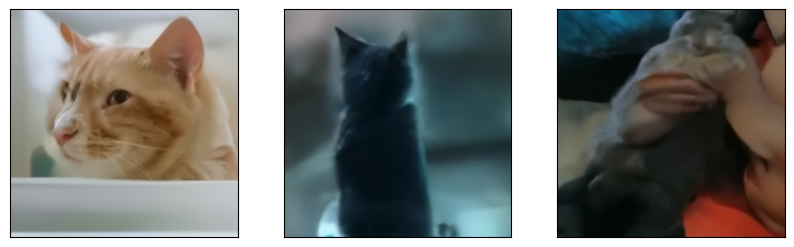

In [6]:
fig, ax = plt.subplots(figsize=(10,3), nrows=1, ncols=3)

for i in range(3):
    ax[i].imshow(images[i])
    ax[i].xaxis.set_major_locator(plt.NullLocator())
    ax[i].yaxis.set_major_locator(plt.NullLocator())

plt.show()

### 모델 & 스케쥴러

- 모델과 스케쥴러를 별도로 임포트하여 노이즈 제거 단계를 직접 수행

In [7]:
# 모델과 스케쥴러 임포트
from diffusers import DDPMScheduler, UNet2DModel

model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")
scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

- 노이즈 제거 프로세스를 실행할 타임스텝 수를 설정

In [8]:
scheduler.set_timesteps(50)

In [9]:
# 1000스탭에서 20씩 건너뛰면서 타입 스탭이 생성
scheduler.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

- 모델과 스케쥴러를 직접 사용하여 노이즈 제거 루프를 구성

In [10]:
# 모델이 생성하는 이미지 사이즈
sample_size = model.config.sample_size
sample_size

256

In [11]:
# 랜덤 노이즈
generator = torch.manual_seed(10)
noise = torch.randn((1, 3, sample_size, sample_size),
                    generator=generator).to('cuda')
noise.shape

torch.Size([1, 3, 256, 256])

#### 단계별 노이즈 제거

In [12]:
input = noise

for t in scheduler.timesteps:
    output = model(input, t)
    break

output

UNet2DOutput(sample=tensor([[[[-0.7927, -0.5451, -0.8257,  ..., -1.4322,  0.9039, -0.1605],
          [ 0.5197, -1.9563, -0.6842,  ..., -0.8022, -0.6639, -2.0225],
          [-0.8390,  0.1852, -0.8285,  ...,  1.0335, -0.0640, -0.5498],
          ...,
          [-0.3346, -1.5271, -0.2874,  ...,  0.2863, -0.8481,  0.9677],
          [-0.2843, -0.8497, -1.1882,  ..., -0.2436, -1.6741, -0.3858],
          [ 1.2129,  1.2365,  1.9128,  ...,  0.2232,  0.3379,  0.9158]],

         [[-1.5686,  0.4024, -0.3167,  ...,  0.9714, -1.2834,  0.3277],
          [-1.3001,  0.7313,  0.7555,  ...,  0.0183, -1.0360, -2.3748],
          [-1.1451,  0.0362,  0.4049,  ...,  1.1379,  0.6682, -0.1657],
          ...,
          [-2.2402,  0.1112, -1.9951,  ...,  1.9983,  0.4434,  0.4791],
          [ 0.0641,  2.7405, -0.6700,  ...,  2.1223,  0.2885, -0.2540],
          [-0.9287, -0.7885,  0.0727,  ..., -0.4011,  3.2191, -2.1067]],

         [[ 1.3919, -0.7729, -2.1064,  ..., -0.9816, -0.8901, -0.8510],
          

In [13]:
for t in scheduler.timesteps:
    # 모델이 노이즈를 예측
    with torch.no_grad():
        noisy_residual = model(input, t).sample

    # 모델의 예측으로 부터 이전 단계(노이즈가 줄어든) 이미지 샘플링
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample

    # input 업데이트
    input = previous_noisy_sample


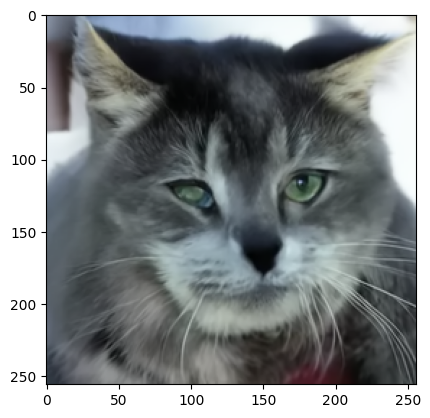

In [14]:
image = (input / 2 + 0.5).clamp(0, 1).squeeze() # [-1, 1] -> [0, 1]
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()

plt.imshow(image)
plt.show()

## Stable Diffusion(SD)

- [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752)에서 제안한 모델을 Stability AI의 투자로 CompVis 그룹과  런웨이 ML(Runway ML), LAION 에서 개발한 구현체

- LDM: https://github.com/CompVis/latent-diffusion

- Stable Diffusion: https://github.com/CompVis/stable-diffusion

- 🤗 Diffusers에서 SD 구성 요소인 이미지 오토인코더, 토크나이저, 텍스트 인코더, 노이즈 제거 모델을 모두 제공

#### 구성요소 준비

In [15]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

In [16]:
# 구성 요소 4개를 생성

# 이미지 <---> 잠재 공간을 담당하는 모델
vae = AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder="vae", use_safetensors=True)

# 텍스트 컨디션을 토크나이징하는 토크나이저
tokenizer = CLIPTokenizer.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder="tokenizer")

# 텍스트 컨디션 인코더
text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder="text_encoder", use_safetensors=True)

# 노이즈 제거 모델
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder="unet", use_safetensors=True
)

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [32]:
from diffusers import UniPCMultistepScheduler

# 우선은 기본 스케쥴러로 실험
scheduler = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

# 스케쥴러 바꾸면 우주인 다리 부분이 좀 깔끔해짐
# scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [18]:
torch_device = "cuda"

vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

#### 프롬프트 준비

In [33]:
prompt = ["a photograph of an astronaut riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(2)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

In [34]:
# 토크나이저로 토크나이징
text_input = tokenizer(
    prompt, max_length=tokenizer.model_max_length,
    padding="max_length", truncation=True, return_tensors="pt"
)

# 시퀀스 길이 77
print(len(text_input['input_ids'][0]))

# 토큰화 결과
text_input

77


{'input_ids': tensor([[49406,   320,  8853,   539,   550, 18376,  6765,   320,  4558, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [35]:
with torch.no_grad():
    text_embeddings = text_encoder(text_input['input_ids'].to(torch_device))[0]

# 각 토큰은 768차원 벡터로 임베딩
text_embeddings.shape

torch.Size([1, 77, 768])

In [36]:
max_length = text_input['input_ids'].shape[-1]

# 텍스트 컨디션이 없는 입력을 만들기 위해
# 텍스트가 모두 ""인 것으로 채워서 널 컨디션을 만듬
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")

uncond_embeddings = text_encoder(uncond_input['input_ids'].to(torch_device))[0]

- 조건부 임베딩과 무조건 임베딩을 일괄 처리로 연결하여 두 번의 포워드 패스를 방지

In [37]:
# (1, 77, 768), (1, 77, 768) => (2, 77, 768)
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# 구체적인 조건이 있는것과 그냥 깡통 조건(모두 공백인)이 같이 묶임
text_embeddings.shape

torch.Size([2, 77, 768])

#### 랜덤 노이즈 생성

In [38]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
).to(torch_device)

In [39]:
# 입력 이미지 사이즈 512가 VAE에서 3번 다운 샘플되서 64 사이즈로 줄어든 잠재 변수
latents.shape

torch.Size([1, 4, 64, 64])

In [40]:
latents

tensor([[[[-1.0408e+00,  9.1660e-01, -1.3042e+00,  ...,  7.7871e-01,
           -7.7485e-01, -1.3975e-01],
          [ 1.1414e+00, -6.3537e-01, -1.4702e+00,  ...,  1.8737e+00,
            1.0122e+00, -1.4482e+00],
          [-6.4352e-02,  3.2155e-01,  5.9075e-01,  ..., -9.7924e-01,
           -1.4392e+00,  6.5084e-01],
          ...,
          [ 5.4770e-01, -1.0995e-01,  1.0554e-01,  ...,  1.5626e+00,
           -6.7273e-01,  7.3529e-01],
          [-1.1437e-01, -2.2427e-01,  2.8413e-01,  ..., -6.0938e-01,
            1.4035e-01,  1.3990e+00],
          [-1.1505e-01,  7.7870e-02,  1.3394e+00,  ..., -3.2418e-01,
           -8.3689e-01,  8.8591e-01]],

         [[-8.5617e-01,  2.4589e+00, -5.7744e-01,  ..., -1.1048e-01,
            1.9661e-01,  1.7086e+00],
          [ 4.6140e-01,  8.3764e-01,  5.1421e-01,  ...,  5.5839e-01,
           -1.2195e+00, -2.6194e+00],
          [-1.9199e-01, -9.4378e-01,  4.7429e-01,  ...,  5.8217e-01,
            2.2116e+00,  8.2109e-01],
          ...,
     

In [41]:
# 3번 업샘플하면 512가 됨
64*2*2*2

512

In [42]:
# 타임스탭 세팅
scheduler.set_timesteps(num_inference_steps)
scheduler.timesteps

tensor([999, 959, 919, 879, 839, 799, 759, 719, 679, 639, 599, 559, 519, 480,
        440, 400, 360, 320, 280, 240, 200, 160, 120,  80,  40])

#### 단계별 노이즈 제거

In [43]:
for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    # 텍스트 컨디션이 있는 입력과 없는 입력을 동시에 처리하기 위해 latents를 두배 확장
    latent_model_input = torch.cat([latents] * 2)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    # 모델의 출력을 두개로 나눔
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    # CFG eq(6)
    # 조건을 주고 예측한 노이즈와 조건 없이 예측한 노이즈를
    # 적당히 섞어 조금 더 조건에 가이드된 노이즈를 계산
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

In [44]:
# scale and decode the image latents with vae
# sigma는 학습된 vae가 생성하는 모든 latent의 표준편차
# x ---> vae encoder ---> z  ===> z / sigma  인코딩된 latent를 sigma로 정규화 ----> unet 디노이징
# 따라서 unet이 출력하는 latent는 sigma로 정규화된 latent기 때문에
# 이를 vae decoder로 넣어주려면 sigma를 곱해야 함
# 0.18215는 sigma의 역수이므로 1/0.18215를 곱해야 함
# Ref.
# LDM논문 부록 G
# https://discuss.huggingface.co/t/what-does-0-18215-mean-in-blog-stable-diffusion-with-diffusers/24993
# https://github.com/huggingface/diffusers/issues/437
# https://huggingface.co/docs/diffusers/v0.30.0/en/api/models/autoencoderkl 에 scale_factor 부분
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

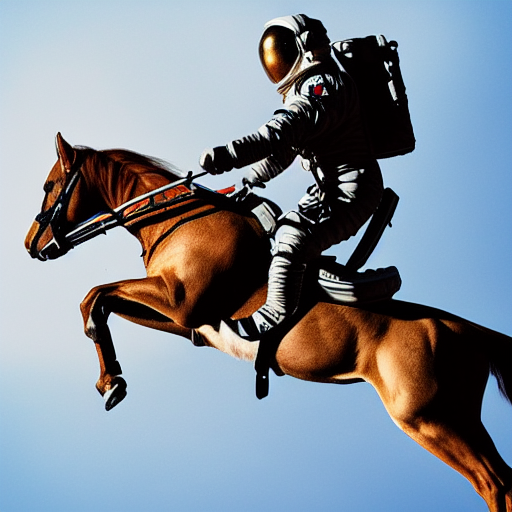

In [45]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image